<a href="https://colab.research.google.com/github/LaJeremi/Tensorflow-nlp-tutorial-Practice-/blob/main/10.%20Text%20Classification/%2010_07%20Naver_Shopping_Review_Sentiment_Analysis_(%EB%84%A4%EC%9D%B4%EB%B2%84_%EC%87%BC%ED%95%91_%EB%A6%AC%EB%B7%B0_%EA%B0%90%EC%84%B1_%EB%B6%84%EB%A5%98).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10_07  Naver Shopping Review Sentiment Analysis (네이버 쇼핑 리뷰 감성 분류)

# 1. Colab에 Mecab 설치


In [ ]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 9.86 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.6/465.6 KB 48.1 MB/s eta 0:00:00
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2023-02-16 07:10:31--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22e9:9f55, 2406:da00:ff00::

In [ ]:
pip install konlpy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from konlpy.tag import Mecab


# 2. 네이버 쇼핑 리뷰 데이터에 대한 이해와 전처리


In [ ]:

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from wordcloud import WordCloud
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1) 데이터 로드하기


In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")


('ratings_total.txt', <http.client.HTTPMessage at 0x7efd41629640>)

해당 데이터에는 열제목이 별도로 없습니다. 그래서 임의로 두 개의 열제목인 'ratings'와 'reviews'를 추가해주겠습니다.

In [ ]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])


In [ ]:
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력


전체 리뷰 개수 : 200000


In [ ]:
total_data[:5]


,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


## 2) 훈련 데이터와 테스트 데이터 분리하기

평점이 4, 5인 리뷰에는 레이블 1을, 평점이 1, 2인 리뷰에는 레이블 0을 부여

중복을 제외한 샘플의 수를 카운트

In [ ]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)


In [ ]:
total_data[:5]


,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [ ]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()


(4, 199908, 2)

ratings열의 경우 1, 2, 4, 5라는 네 가지 값을 가지고 있습니다. 

reviews열에서 중복을 제외한 경우 199,908개입니다. 

현재 20만개의 리뷰가 존재하므로 이는 현재 갖고 있는 데이터에 중복인 샘플들이 있다는 의미

In [ ]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거


In [ ]:
print('총 샘플의 수 :',len(total_data))


총 샘플의 수 : 199908


In [ ]:
print(total_data.isnull().values.any())
# NULL 값 유무를 확인합니다.



False


In [ ]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)


훈련 데이터와 테스트 데이터를 3:1 비율로 분리

In [ ]:

print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


# 약 14만 9,900개. 테스트용 리뷰의 경우 약 4만 9,900개

# 3) 레이블의 분포 확인

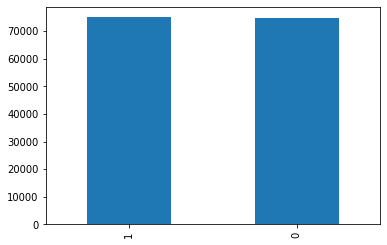

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar')


In [ ]:
print(train_data.groupby('label').size().reset_index(name = 'count'))


   label  count
0      0  74918
1      1  75013


두 레이블 모두 약 7만 5천개로 50:50 비율

# 4) 데이터 정제하기

한글을 제외하고 모두 제거

-> 빈 샘플이 생기지는 않는지 확인

In [ ]:
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

<ipython-input-19-c34eb9d0d54a>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,ratings,reviews,label
59666,2,사이즈를 센치씩 늘린건데도 작아요 그리고 색상은 완전 달라요 칙칙한핑크네요ㅠㅠ 많이...,0
12433,2,ㅂ불만족 빗이 아픔 멍이피부에 빗질못해주겟네요,0
146516,1,이 제품쓰고 삼일만에 변기물이 잘 안내려갔어요 혹시나해서 다시 빼보니 물이 다시 잘...,0
158109,5,적당하고 만족합니다,1
70219,2,편하자고 이용하는 밀키튼데 손 은근 많이 가서 저는 패쓰요,0


In [ ]:
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


### * 테스트 데이터에 대해서도 같은 과정

In [ ]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


<ipython-input-21-95386e1de338>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


# 5) 토큰화

형태소 분석기 Mecab을 사용하여 토큰화 작업을 수행

다음은 임의의 문장에 대해서 테스트한 토큰화 결과

In [ ]:

mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


## *불용어를 지정하여 필요없는 토큰들은 제거

In [ ]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']


훈련 데이터와 테스트 데이터에 대해서 동일한 과정

In [ ]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [ ]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


In [ ]:
from collections import Counter


In [ ]:
train_data[train_data.label == 0]['tokenized'].values


array([list(['사이즈', '센치', '씩', '늘린', '건데', '작', '아요', '그리고', '색상', '완전', '달라요', '칙칙', '핑크', '네요', 'ㅠㅠ', '많이', '아쉽', '지만', '암막', '효과', '좋', '아요']),
       list(['ㅂ', '불', '만족', '빗이', '아픔', '멍', '피부', '빗', '질', '못해', '주', '겟', '네요']),
       list(['제품', '쓰', '삼', '일', '만', '변기', '물', '잘', '안', '내려갔', '어요', '혹시나', '해서', '다시', '빼', '보', '니', '물', '다시', '잘', '내려가', '네요', '많', '걸', '어쩌', '나요', '반품', '싶']),
       ...,
       list(['그냥', '그래요', 'ㄷ', 'ㄷ', 'ㄷ', 'ㄷ', 'ㅂ', 'ㅂ', 'ㅂ', 'ㅂ', '그냥', '그래요', 'ㄷ', 'ㄷ', 'ㄷ', 'ㄷ', 'ㅂ', 'ㅂ', 'ㅂ', 'ㅂ', 'ㅁ', 'ㅁ', 'ㅁ', 'ㅁ', 'ㅋㅋ', 'ㅋㅋ', 'ㅌㅌㅌㅌㅍㅍㅍㅍ', 'ㄹ', 'ㄹ', 'ㄹ', 'ㄹ', 'ㄱ', 'ㄱ', 'ㄱ', 'ㄱ', 'ㅎㅎ', 'ㅎㅎ', 'ㄱ', 'ㄱ', 'ㄱ', 'ㄱ', 'ㄷ', 'ㄷ', 'ㄷ', 'ㄷ', 'ㅈ', 'ㅈ', 'ㅈ', 'ㅈ', 'ㅂ', 'ㅂ', 'ㅂ', 'ㅂ']),
       list(['비싸', '요', '진짜', '별거', '아니', '허접', '생겼', '는데', '이게', '만', '원', '라니', '진짜', '가방', '구겨지', '것', '만', '아니', '면', '구매', '안', '했', '음']),
       list(['장', '주문', '안', '됩니다', '장', '가능', '해요'])], dtype=object)

# 6) 단어와 길이 분포 확인하기

긍정 리뷰에는 주로 어떤 단어들이 많이 등장

부정 리뷰에는 주로 어떤 단어들이 등장하는지 두 가지 경우에 대해서 각 단어의 빈도수를 계산


## 단어들의 리스트를 저장

In [ ]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

# 우선 부정 리뷰에 대해서 빈도수가 높은 상위 20개 단어들을 출력

In [ ]:
negative_word_count = Counter(negative_words) # 파이썬의 Counter 모듈을 이용하면 단어의 모든 빈도를 쉽게 계산할 수 있습니다.
print(negative_word_count)

Counter({'네요': 31799, '는데': 20295, '안': 19718, '어요': 14849, '있': 13200, '너무': 13058, '했': 11783, '좋': 9812, '배송': 9677, '같': 8997, '구매': 8876, '어': 8869, '거': 8854, '없': 8670, '아요': 8642, '습니다': 8436, '그냥': 8355, '되': 8345, '잘': 8029, '않': 7984, '나': 7612, '요': 7406, '만': 6792, '것': 6401, '기': 6389, '로': 6269, '쓰': 5878, '아서': 5822, '해서': 5637, '주': 5619, '서': 5600, '별로': 5480, '면': 5456, '으로': 5437, '좀': 5340, '았': 5326, '었': 5323, '보다': 5305, '아': 5266, '먹': 5247, '겠': 5242, '보': 5138, '사용': 5110, '제품': 5089, '생각': 4867, '개': 4845, '어서': 4547, 'ㅠㅠ': 4478, '지만': 4395, '음': 4367, '받': 4250, '해': 4236, '왔': 4193, '재': 4125, '주문': 4117, '맛': 4075, '합니다': 4030, '작': 3999, '시': 3870, '많이': 3832, '입니다': 3815, '라': 3703, '더': 3698, '번': 3666, '에서': 3617, '가격': 3612, '사': 3538, '니': 3527, 'ㅠ': 3513, '못': 3513, '해요': 3497, '아니': 3352, '할': 3334, '샀': 3321, '사이즈': 3306, '때': 3306, '부분': 3222, '맞': 3214, '다른': 3181, '반품': 3138, '두': 3122, '입': 3080, '냄새': 2889, '하나': 2797, '상품': 2738, '일': 2685,

'네요', '는데', '안', '않', '너무', '없' 등과 같은 단어들이 부정 리뷰에서 주로 등장합니다. 

긍정 리뷰에 대해서도 출력

In [ ]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

In [ ]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))



'좋', '아요', '네요', '잘', '너무', '만족' 등과 같은 단어들이 주로 많이 등장합니다. 

두 가지 경우에 대해서 각각 길이 분포를 확인

긍정 리뷰의 평균 길이 : 13.5877381253916
부정 리뷰의 평균 길이 : 17.029498918817907


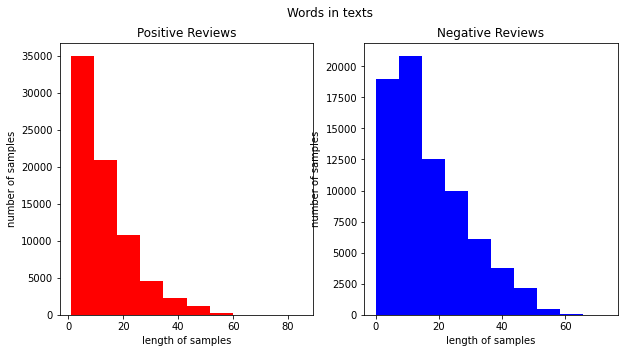

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [ ]:

test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
     

In [ ]:

X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [ ]:
X_train[:3]


array([list(['사이즈', '센치', '씩', '늘린', '건데', '작', '아요', '그리고', '색상', '완전', '달라요', '칙칙', '핑크', '네요', 'ㅠㅠ', '많이', '아쉽', '지만', '암막', '효과', '좋', '아요']),
       list(['ㅂ', '불', '만족', '빗이', '아픔', '멍', '피부', '빗', '질', '못해', '주', '겟', '네요']),
       list(['제품', '쓰', '삼', '일', '만', '변기', '물', '잘', '안', '내려갔', '어요', '혹시나', '해서', '다시', '빼', '보', '니', '물', '다시', '잘', '내려가', '네요', '많', '걸', '어쩌', '나요', '반품', '싶'])],
      dtype=object)

In [ ]:
y_train[:3]


array([0, 0, 0])

긍정 리뷰보다는 부정 리뷰가 좀 더 길게 작성된 경향

# 7) 정수 인코딩

기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행

훈련 데이터에 대해서 단어 집합(vocaburary)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

## 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여

이는 tokenizer.word_index를 출력하여 확인 가능

등장 횟수가 1회인 단어들은 자연어 처리에서 배제

. 이 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인


In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 39997
등장 빈도가 1번 이하인 희귀 단어의 수: 18212
단어 집합에서 희귀 단어의 비율: 45.53341500612546
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7935259575621343


### 단어가 약 40,000개가 존재합니다. 

* 등장 빈도가 threshold 값인 2회 미만. 즉, 1회인 단어들은 단어 집합에서 약 45%를 차지

* 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 매우 적은 수치인 약 0.8%

* 등장 빈도수가 1인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한



In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21787


단어 집합의 크기는 21,787개

 이를 토크나이저의 인자로 넘겨주고, 텍스트 시퀀스를 정수 시퀀스로 변환

 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV로 변환

In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(tokenizer.word_index)


{'OOV': 1, '네요': 2, '좋': 3, '어요': 4, '는데': 5, '아요': 6, '잘': 7, '있': 8, '구매': 9, '안': 10, '배송': 11, '습니다': 12, '했': 13, '너무': 14, '같': 15, '거': 16, '어': 17, '먹': 18, '합니다': 19, '되': 20, '재': 21, '요': 22, '기': 23, '쓰': 24, '않': 25, '없': 26, '것': 27, '아': 28, '해서': 29, '사용': 30, '로': 31, '았': 32, '나': 33, '으로': 34, '만': 35, '보다': 36, '었': 37, '주': 38, '겠': 39, '지만': 40, '보': 41, '아서': 42, '그냥': 43, '해': 44, '서': 45, '제품': 46, '면': 47, '어서': 48, '가격': 49, '해요': 50, '좀': 51, '만족': 52, '생각': 53, '주문': 54, '입니다': 55, '라': 56, '더': 57, '받': 58, '니': 59, '맛': 60, '할': 61, '많이': 62, '개': 63, '사': 64, '때': 65, '시': 66, '사이즈': 67, '에서': 68, '빠르': 69, '왔': 70, '샀': 71, '번': 72, '작': 73, '별로': 74, '음': 75, '맛있': 76, 'ㅠㅠ': 77, '포장': 78, '입': 79, '수': 80, '두': 81, '맞': 82, '던': 83, '다른': 84, '저렴': 85, '괜찮': 86, '세요': 87, '넘': 88, '못': 89, '상품': 90, '정말': 91, '하나': 92, '아니': 93, '에요': 94, 'ㅠ': 95, '냄새': 96, '데': 97, '부분': 98, '딱': 99, '감사': 100, '아주': 101, '용': 102, '인데': 103, 'ㅎㅎ': 104, '일': 105, '으면'

In [ ]:
print(X_train[:3])


[[67, 2060, 299, 14260, 263, 73, 6, 236, 168, 137, 805, 2951, 625, 2, 77, 62, 207, 40, 1343, 155, 3, 6], [482, 409, 52, 8530, 2561, 2517, 339, 2918, 250, 2357, 38, 473, 2], [46, 24, 825, 105, 35, 2372, 160, 7, 10, 8061, 4, 1319, 29, 140, 322, 41, 59, 160, 140, 7, 1916, 2, 113, 162, 1379, 323, 119, 136]]


In [ ]:
print(X_test[:3])


[[14, 704, 767, 116, 186, 252, 12], [339, 3904, 62, 3816, 1651], [11, 69, 2, 49, 164, 3, 27, 15, 6, 513, 289, 17, 92, 110, 564, 59, 7, 2]]


# 8) 패딩

패딩 작업을 진행

전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.307528129606286


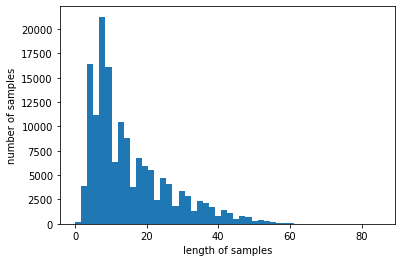

In [ ]:

print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 리뷰의 최대 길이는 85, 평균 길이는 약 15

### 전체적으로는 60이하의 길이를 가지는 것으로 보입니다.

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

# 최대 길이가 85이므로 만약 80으로 패딩할 경우, 몇 개의 샘플들을 온전히 보전할 수 있는지 확인 후 패딩

In [ ]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 100.0


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# 3. GRU로 네이버 쇼핑 리뷰 감성 분류하기

하이퍼파라미터인 임베딩 벡터의 차원은 100, 은닉 상태의 크기는 128

모델은 다 대 일 구조의 LSTM를 사용

-----

이진 분류 문제를 수행하는 모델

이진 분류 문제의 경우, 출력층에 로지스틱 회귀를 사용

활성화 함수로는 시그모이드 함수를 사용

손실 함수로 크로스 엔트로피 함수를 사용

하이퍼파라미터인 배치 크기는 64이며, 15 에포크를 수행

-----

* EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)는 검증 데이터 손실(val_loss)이 증가

* 과적합 징후므로 검증 데이터 손실이 4회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)

*  ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장

* validation_split=0.2을 사용하여 훈련 데이터의 20%를 검증 데이터로 분리해서 사용

증 데이터를 통해서 훈련이 적절히 되고 있는지 확인합니다. 검증 데이터는 기계가 훈련 데이터에 과적합되고 있지는 않은지 확인하기 위한 용도로 사용



In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2935 - acc: 0.8873
Epoch 1: val_acc improved from -inf to 0.91163, saving model to best_model.h5
1875/1875 [==============================] - 49s 22ms/step - loss: 0.2935 - acc: 0.8873 - val_loss: 0.2440 - val_acc: 0.9116
Epoch 2/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2289 - acc: 0.9180
Epoch 2: val_acc improved from 0.91163 to 0.91643, saving model to best_model.h5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.2289 - acc: 0.9180 - val_loss: 0.2264 - val_acc: 0.9164
Epoch 3/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2070 - acc: 0.9266
Epoch 3: val_acc improved from 0.91643 to 0.92357, saving model to best_model.h5
1875/1875 [==============================] - 16s 9ms/step - loss: 0.2070 - acc: 0.9266 - val_loss: 0.2145 - val_acc: 0.9236
Epoch 4/15
1875/1875 [==============================] - ETA: 0s - loss: 0.1931 - acc: 0.9319
Epoch 4: val_ac

에포크 9에서 조기 종료가 발생했습니다.

# 4. 리뷰 예측해보기

정규 표현식을 통한 한국어 외 문자 제거, 토큰화, 불용어 제거, 정수 인코딩, 패딩 순

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 5s 3ms/step - loss: 0.2205 - acc: 0.9228

 테스트 정확도: 0.9228


In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [ ]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')


1/1 [==============================] - 0s 345ms/step
96.11% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')


1/1 [==============================] - 0s 23ms/step
99.74% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('판매자님... 너무 짱이에요.. 대박나삼')


1/1 [==============================] - 0s 22ms/step
96.79% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아')


1/1 [==============================] - 0s 22ms/step
95.45% 확률로 부정 리뷰입니다.
